### Librerias

In [4]:
#Cargando librerias
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K

### Cargando el modelo y seleccionando las capas convolucionales

In [5]:
#Cargando el modelo y el estimulo
model = load_model("D:/Documentos/modelos/CONV-GRAD-CAM.h5")
estimulo = cv2.imread("D:/Documentos/6/19.png")

#Procesando el estimulo
img_array = np.asarray(estimulo)
tamanio = cv2.resize(img_array, (224, 224))
gray = cv2.cvtColor(tamanio, cv2.COLOR_BGR2GRAY)
hist = cv2.equalizeHist(gray)
img = hist/255
img = img.reshape(1, 224, 224, 1)

capa1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
capa2 = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

### Predicción de la clase a la que pertenece el estímulo

In [10]:
#Predicción de la clase
clase = ["Fractal",  "Paisaje natural", "Ruido rosa", "Página web"]
categoria = clase[prediccion[0]]
categoria

'Fractal'

### Mostrando los mapas de características de la primera capa convolucional

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


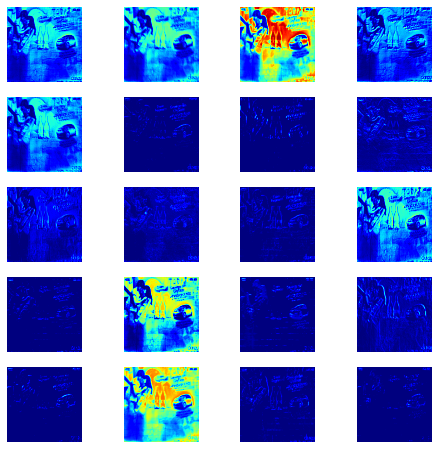

In [6]:
prominencia= capa1.predict(img)
plt.figure(figsize = (8, 8))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(prominencia[0, : ,  :, i], cmap = plt.get_cmap("jet"))
    plt.axis("off")

### Mostrando los mapas de características de la segunda capa convolucional

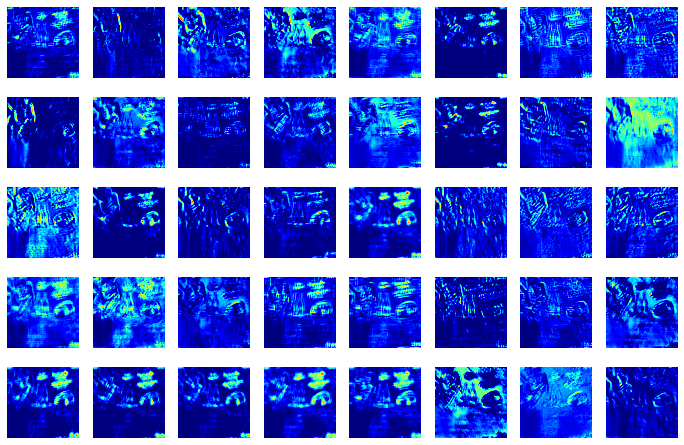

In [7]:
prominencia= capa2.predict(img)
plt.figure(figsize = (12, 8))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.imshow(prominencia[0, : ,  :, i], cmap = plt.get_cmap("jet"))
    plt.axis("off")

### Generando el mapa de activación

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


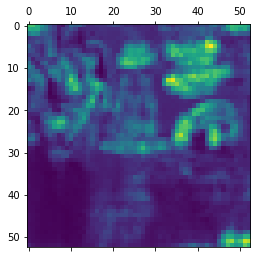

In [8]:
prediccion = model.predict_classes(img)

#Seleccionar la ultima capa
clase_output = model.output[:, prediccion[0]]
last_conv_layer = model.get_layer('max_pooling2d_1')

# Gradiente para la clase predicha a tráves de la ultima capa convolucional
grads = K.gradients(clase_output, last_conv_layer.output)[0]

# Cada entrada es la intensidad media del gradiente sobre un canal del mapa de características específico
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accede a los valores que acabamos de definir para la imagen de muestra
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Valores de pooled_grads_value, conv_layer_output_value dada la imagen de entrada
pooled_grads_value, conv_layer_output_value = iterate([img])

# Multiplicamos cada canal de la matriz del mapa de características por la 'importancia'
# de este canal con respecto a la imagen de entrada
for i in range(30): #EL RANGO DE VALORES VA DESDE 1 HASTA EL NUMERO DE FILTROS DE LA ULTIMA CAPA CONVOLUCIONAL
    #La media por el canal del mapa de características resultante es el mapa de calor del CAM
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
#Generación del mapa de calor al tamaño del filtro
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
fijaciones = heatmap 

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Generando el mapa de calor

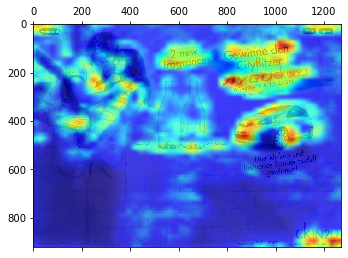

In [9]:
    # Redimensionamiento y superposición del mapa de calor al estímulo
    # We load the original image
    img = keras.preprocessing.image.img_to_array(estimulo)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap *3 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Display heatmap
plt.matshow( superimposed_img)
plt.show()